In [1]:
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os

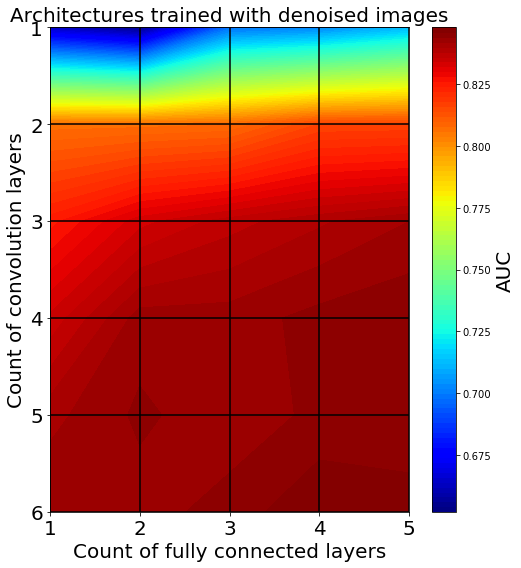

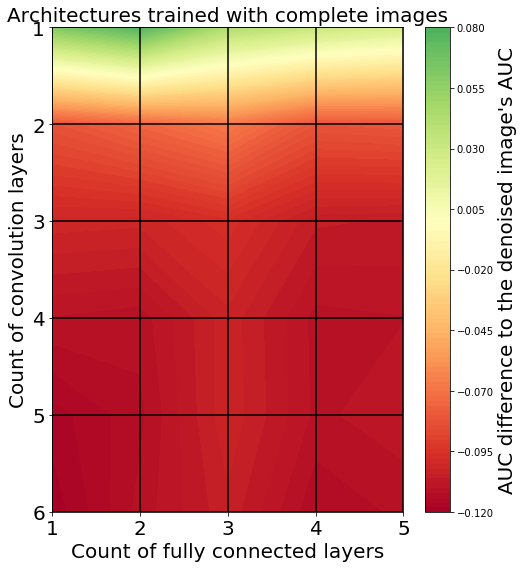

In [2]:
main_path = '/fhgfs/users/jbehnken/make_Data/architectures'
folders = [os.path.join(main_path, folder) for folder in os.listdir(main_path)]
titles = ['Compare_diffuse_flat_architectures', 'Compare_architectures']
path_build = '/home/jbehnken/07_make_FACT/build/'

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


heatmaps = []
for title in titles:
        
    heatmap_data = []
    for folder in folders:
        architecture =  folder.split('_')[-1]
        df = pd.read_csv(os.path.join(folder, architecture+'_Hyperparameter.csv'))
        heatmap_data.append([title, architecture, df[df['Title']==title].sort_values(by='Auc', ascending=False).head(10)['Auc'].mean()])
    heatmaps.append(heatmap_data)

matrices = []
for heatmap_data in heatmaps:
    matrix = np.ones((6, 5))
    for arch in heatmap_data:
        c = arch[1].count('c')-1
        f = arch[1].count('f')-1
        matrix[c, f] = arch[2]
    matrices.append(matrix)

font_big = 20
font_small = 20

plt.figure(figsize=(7.5,8))
plt.contourf(matrices[0], 100, cmap='jet')
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.set_ticks(np.arange(0.0, 1.0, 0.025), update_ticks=True)
cbar.ax.set_ylabel('AUC', fontsize=font_small)

plt.yticks(range(6), range(1,7), fontsize=font_small)
plt.xticks(range(5), range(1,6), fontsize=font_small)

plt.title('Architectures trained with denoised images', fontsize=font_big)
plt.xlabel('Count of fully connected layers', fontsize=font_small)
plt.ylabel('Count of convolution layers', fontsize=font_small)

for i in range(6):
    plt.plot([0,4], [i, i], 'k')
for i in range(5):
    plt.plot([i,i], [0, 5], 'k')

plt.tight_layout()
plt.savefig(path_build+'Architectures_AUC_denoised.pdf')
plt.show()


elev_min = -0.12
elev_max = 0.12

plt.figure(figsize=(7.5,8))
plt.contourf(matrix[1]-matrices[0], 100, cmap='RdYlGn', clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=0,vmin=elev_min, vmax=elev_max))
plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.set_ticks(np.arange(elev_min, elev_max, 0.025), update_ticks=True)
cbar.ax.set_ylabel("AUC difference to the denoised image's AUC", fontsize=font_small)

plt.yticks(range(6), range(1,7), fontsize=font_small)
plt.xticks(range(5), range(1,6), fontsize=font_small)

plt.title('Architectures trained with complete images', fontsize=font_big)
plt.xlabel('Count of fully connected layers', fontsize=font_small)
plt.ylabel('Count of convolution layers', fontsize=font_small)

for i in range(6):
    plt.plot([0,4], [i, i], 'k')
for i in range(5):
    plt.plot([i,i], [0, 5], 'k')

plt.tight_layout()
plt.savefig(path_build+'Architectures_AUC_noised.pdf')
plt.show()

In [3]:
time = []
for folder in folders:
    architecture =  folder.split('_')[-1]
    
    df = pd.read_csv(os.path.join(folder, architecture+'_Hyperparameter.csv'))
    time.append([architecture, df[df['Title']==titles[0]]['Time'].values])

np_time = []
for arch in time:
    np_time.extend(arch[1])
    if len(arch[1])!=50:
        print(arch[0], len(arch[1]), np.mean(arch[1]))
np_time = np.array(np_time)

print('\nMean: {}\nStd: {}'.format(np.mean(np_time), np.std(np_time)))

t = np.mean(np_time)*(1500-len(np_time))/3600
h = int(t)
m = int(60*(t%1))
s = int(round(60*((60*(t%1))%1)))

print('\nRestdauer: {}h {}m {}s'.format(h, m, s))


Mean: 246.41608617194493
Std: 677.4750260910282

Restdauer: 0h 0m 0s


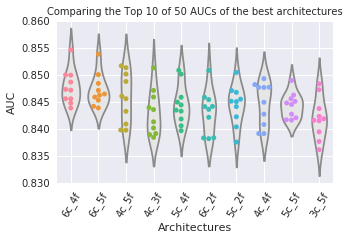

In [4]:
import seaborn as sns

path_build = '/home/jbehnken/07_make_FACT/build/'

for title in titles[:1]:
    comparison_names = []
    comparison_auc = []
    for folder in folders:
        architecture =  folder.split('_')[-1]
        c = architecture.count('c')
        f = architecture.count('f')

        name_new = str(c)+'c_'+str(f)+'f'
        comparison_names.append(name_new)


        df = pd.read_csv(os.path.join(folder, architecture+'_Hyperparameter.csv'))
        comparison_auc.append(df[df['Title']==title].sort_values(by='Auc', ascending=False).head(10)['Auc'].values.tolist())
        
        
    df_plot = pd.DataFrame(np.array(comparison_auc).T, columns=comparison_names)
    df_plot = df_plot[df_plot.max().sort_values(ascending=False).index]

    df_swarm = pd.melt(df_plot)[:100]
    df_swarm.columns = ['Architectures', 'AUC']
    sns.set(style='darkgrid', font='DejaVu Sans')
    plt.figure(figsize=(5, 3.5))
    plt.title('Comparing the Top 10 of 50 AUCs of the best architectures', fontsize=10)
    sns.violinplot(x="Architectures", y="AUC", data=df_swarm, inner=None, color=".9")
    sns.swarmplot(x="Architectures", y="AUC", data=df_swarm)
    plt.xticks(rotation=60)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.savefig(path_build+'Best_denoised_architectures.pdf')
    plt.show()

In [5]:
title = 'Compare_diffuse_flat_architectures'
comparison_names = []
comparison_auc = []
for folder in folders:
    architecture =  folder.split('_')[-1]
    c = architecture.count('c')
    f = architecture.count('f')
    
    name_new = str(c)+'c_'+str(f)+'f'
    comparison_names.append(name_new)

    df = pd.read_csv(os.path.join(folder, architecture+'_Hyperparameter.csv'))
    
    for values in df[(df['Title']==title) & (df['Early_Stopped']==True)][['Auc', 'Batch_Size', 'Patch_Size', 'Depth_1', 'Hidden_Nodes']].values:
        comparison_auc.append([name_new, values[0], values[1], values[2], values[3], values[4]])
        
df_parameter = pd.DataFrame(comparison_auc, columns=['Name', 'Auc', 'Batch_Size', 'Patch_Size', 'Depth_1', 'Hidden_Nodes'])

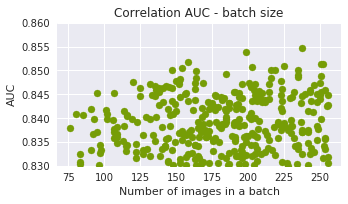

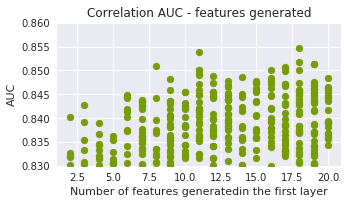

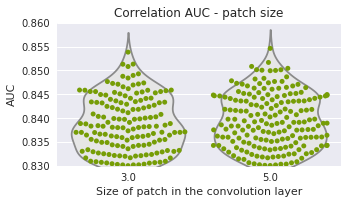

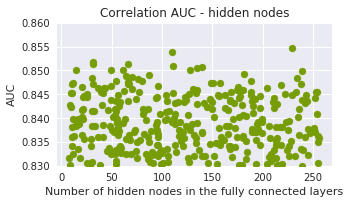

In [6]:
color = (118/255, 157/255, 6/255)
path_build = '/home/jbehnken/07_make_FACT/build/'

plt.figure(figsize=(5, 3))
df_plot = df_parameter[df_parameter['Auc']>0.83]
plt.scatter(x=df_plot['Batch_Size'], y=df_plot['Auc'], color=color)
plt.ylim(0.83, 0.86)
plt.title('Correlation AUC - batch size')
plt.xlabel('Number of images in a batch')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(path_build+'Best_Hyperparameter_Batch_Size.pdf')
plt.show()

plt.figure(figsize=(5, 3))
plt.scatter(x=df_plot['Depth_1'], y=df_plot['Auc'], color=color)
plt.ylim(0.83, 0.86)
plt.title('Correlation AUC - features generated')
plt.xlabel('Number of features generatedin the first layer')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(path_build+'Best_Hyperparameter_Depth_1.pdf')
plt.show()

plt.figure(figsize=(5, 3))
sns.swarmplot(x=df_plot['Patch_Size'], y=df_plot['Auc'], color=color)
sns.violinplot(x=df_plot['Patch_Size'], y=df_plot['Auc'], inner=None, color=".9")
plt.ylim(0.83, 0.86)
plt.title('Correlation AUC - patch size')
plt.xlabel('Size of patch in the convolution layer')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(path_build+'Best_Hyperparameter_Patch_Size.pdf')
plt.show()

plt.figure(figsize=(5, 3))
plt.scatter(x=df_plot['Hidden_Nodes'], y=df_plot['Auc'], color=color)
plt.ylim(0.83, 0.86)
plt.title('Correlation AUC - hidden nodes')
plt.xlabel('Number of hidden nodes in the fully connected layers')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(path_build+'Best_Hyperparameter_Hidden_Nodes.pdf')
plt.show()

In [7]:
arch_dict = {name:arch for name, arch in zip(['Compare_diffuse_flat_dropout_architectures_{}'.format(i) for i in range(10)], ['c_d_5c_4f', '2c_d_4c_4f', '3c_d_3c_4f', '4c_d_2c_4f', '5c_d_c_4f', '6c_d_4f', '6c_f_d_3f', '6c_2f_d_2f', '6c_3f_d_f', '6c_4f'])}

In [8]:
dropout_path = '/fhgfs/users/jbehnken/make_Data/architectures/29_ccccccffff/ccccccffff_Hyperparameter.csv'
df = pd.read_csv(dropout_path)

top = 5

values = []
dropout_names = list(df['Title'].unique())[2:]
for name in dropout_names:
    df_t = df[df['Title']==name]
    name = arch_dict[name]
    for value in df_t.sort_values(by='Auc', ascending=False)['Auc'].head(top).values:
        values.append([name, value])
    print(df_t.shape, '\t', name, '\t', df_t['Time'].mean())

(37, 16) 	 c_d_5c_4f 	 124.21813049187531
(33, 16) 	 2c_d_4c_4f 	 181.57546343947902
(28, 16) 	 3c_d_3c_4f 	 124.75120855229241
(31, 16) 	 4c_d_2c_4f 	 135.2115959505881
(16, 16) 	 5c_d_c_4f 	 121.30593603849411
(18, 16) 	 6c_d_4f 	 177.80021675427756
(34, 16) 	 6c_f_d_3f 	 145.03813709932214
(32, 16) 	 6c_2f_d_2f 	 120.49450274556875
(24, 16) 	 6c_3f_d_f 	 175.02507235606512
(14, 16) 	 6c_4f 	 138.9901657955987


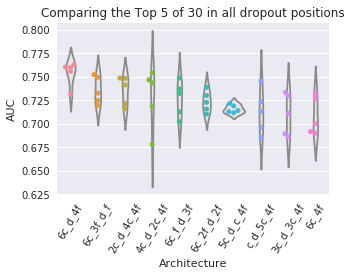

In [9]:
df = pd.DataFrame(values, columns=['Architecture', 'AUC'])
order = df.groupby('Architecture').mean().sort_values(by='AUC', ascending=False).index.tolist()

plt.figure(figsize=(5, 4))
sns.violinplot(x="Architecture", y="AUC", data=df, inner=None, color=".9", order=order)
sns.swarmplot(x="Architecture", y="AUC", data=df, order=order)
plt.title('Comparing the Top {} of 30 in all dropout positions'.format(top))
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig(path_build+'Dropout_Positions.pdf')
plt.show()

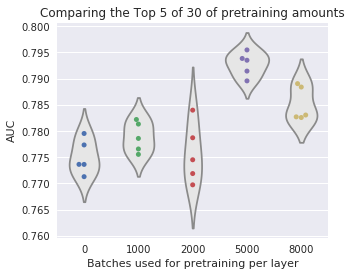

In [10]:
df = pd.read_csv('/fhgfs/users/jbehnken/pretraining.csv')

new = []
for pretraining in df['Pretraining'].unique():
    #print(pretraining, df[df['Pretraining']==pretraining].shape)
    for row in df[df['Pretraining']==pretraining].sort_values(by='Auc', ascending=False).head(5).values:
        new.append(row)
df_new = pd.DataFrame(new, columns=['Accuracy', 'AUC', 'Pretraining amount'])

plt.figure(figsize=(5, 4))
sns.violinplot(x="Pretraining amount", y="AUC", data=df_new, inner=None, color=".9")
sns.swarmplot(x="Pretraining amount", y="AUC", data=df_new)
plt.title('Comparing the Top 5 of 30 of pretraining amounts')
plt.xticks(range(5), [0, 1000, 2000, 5000, 8000])
#plt.xticks(rotation=60)
plt.xlabel('Batches used for pretraining per layer')
plt.tight_layout()
#plt.savefig(path_build+'Pretraining_Amounts.pdf')
plt.show()